# Beer Image Processing
#### Using cv2 and tensorflow (DNN and LSTM) 

## IMPORTING

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## PREPROCESSING

In [2]:
def get_beer_color(image):
    # Resize the image
    cropped_image = image[94:118, 114:138] # 24 x 24
    
    # Calculate the average color (BGR format)
    avg_color = cv2.mean(cropped_image)[:3]
    
    avg_color_rgb = avg_color[::-1]

    return avg_color_rgb

In [3]:
def get_sediment_image(image):
    # Resize the image
    image = image[212:252, 114:158] # 48 x 40
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    
    return image

In [4]:
def get_foam_image(image):
    # Resize the image
    image = image[14:96, 96:108] # 12 x 72
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
        
    return image

In [5]:
def normalize(image):
    # normalization for visualisation
    image_data_type = image.dtype

    if image_data_type == np.float32 or image_data_type == np.float64:
        # Normalize the float image to the range [0, 1]
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        # Convert the image to float and normalize it to the range [0, 1]
        normalized_image = image.astype(np.float32) / 255.0

    return normalized_image
    

In [6]:
def get_height(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Increase the brightness and contrast of the image
    image = cv2.convertScaleAbs(image, alpha=0.68, beta=14)

    # Convert the grayscale image back to RGB
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Convert the HSV image to grayscale
    gray = cv2.cvtColor(hsv, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create the mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Initialize min and max height variables
    min_height = None
    max_height = None

    # Iterate through the mask to find the highest and lowest points with continuous color
    for y in range(mask.shape[0]):
        # Check if the current row contains continuous color
        if np.all(mask[y, :] > 0):
            if min_height is None:
                min_height = y
            max_height = y

    # Calculate the height
    if min_height is not None and max_height is not None:
        height = max_height - min_height + 1
    else:
        height = 0

    return height


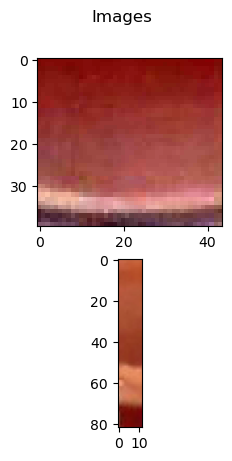

In [7]:
import glob
import os

# Get all .jpg image paths in a folder
folder_path = "../PythonArduino/PythonCode/images/"
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

# Sort image paths based on their names (assuming they are named with ascending timestamps)
image_paths.sort()

# Set corresponding timestamps for each image
timestamps = list(range(len(image_paths)))  # Using indices as timestamps, you can replace them with actual timestamps if available

fig, axs = plt.subplots(2)
fig.suptitle('Images')

data = []
for image_path, timestamp in zip(image_paths, timestamps):
      
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = image[224:480, 244:500] # 256 x 256
    
    # sediment
    sediment_image = get_sediment_image(image)
    sediment_image = normalize(sediment_image)
    axs[0].imshow(cv2.cvtColor(sediment_image, cv2.COLOR_BGR2RGB))
    sediment_height= get_height(sediment_image)
    
    # foam
    foam_image = get_foam_image(image)
    foam_image = normalize(foam_image)
    axs[1].imshow(cv2.cvtColor(foam_image, cv2.COLOR_BGR2RGB))
    foam_height= get_height(foam_image)
    
    # beer color
    beer_color = get_beer_color(image)
    
    data.append([timestamp, foam_height, beer_color, sediment_height])

# Convert data to a DataFrame
df = pd.DataFrame(data, columns=["timestamp", "foam_height", "beer_color", "sediment_height"])


In [8]:
def rgb_to_gray(rgb_tuple):
    R, G, B = rgb_tuple
    return 0.2989 * R + 0.5870 * G + 0.1140 * B

# Convert the beer_color column to grayscale
df["beer_color"] = df["beer_color"].apply(rgb_to_gray)

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Add fermentation progress to the DataFrame
fermentation_progress = [] # List of fermentation progress values corresponding to each image
for i in range(len(image_paths)):
    fermentation_progress.append(round((100 / (len(image_paths) - 1)) * i, 2))

df["fermentation_progress"] = fermentation_progress
df.head()

,timestamp,foam_height,beer_color,sediment_height,fermentation_progress
0,0,82,69.704094,40,0.0
1,1,82,69.711496,40,25.0
2,2,82,65.245200,40,50.0
3,3,82,68.506192,40,75.0
4,4,82,60.283568,40,100.0


In [10]:
# Define input and output columns
input_columns = ["foam_height", "beer_color", "sediment_height"]
output_column = "fermentation_progress"

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df[input_columns])

# Prepare the output values
y = df[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape the input data for LSTM (samples, timesteps, features)
timesteps = 1
X_train = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [11]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100


C:\Users\mark9\.conda\envs\ML-ENV\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 3s 3s/step - loss: 1041.9755 - mae: 25.0081 - val_loss: 5625.4946 - val_mae: 75.0033
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 1041.8231 - mae: 25.0030 - val_loss: 5624.7974 - val_mae: 74.9986
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 1041.4723 - mae: 24.9986 - val_loss: 5624.0889 - val_mae: 74.9939
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 1041.6202 - mae: 25.0018 - val_loss: 5623.3911 - val_mae: 74.9893
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 1041.0886 - mae: 24.9955 - val_loss: 5622.6929 - val_mae: 74.9846
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 1040.9476 - mae: 24.9960 - val_loss: 5621.9951 - val_mae: 74.9800
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 1040.6022 - mae: 24.9908 - val_loss: 5621.2998 - val_mae: 74.9753
Epoch 8/100
1/1 [==============================]

1/1 [==============================] - 0s 23ms/step - loss: 1015.5972 - mae: 24.8049 - val_loss: 5537.9658 - val_mae: 74.4175
Epoch 61/100
1/1 [==============================] - 0s 38ms/step - loss: 1015.6457 - mae: 24.7952 - val_loss: 5534.2354 - val_mae: 74.3924
Epoch 62/100
1/1 [==============================] - 0s 23ms/step - loss: 1014.7553 - mae: 24.8373 - val_loss: 5530.3594 - val_mae: 74.3664
Epoch 63/100
1/1 [==============================] - 0s 23ms/step - loss: 1011.5295 - mae: 24.8170 - val_loss: 5526.3003 - val_mae: 74.3391
Epoch 64/100
1/1 [==============================] - 0s 24ms/step - loss: 1016.0403 - mae: 24.9126 - val_loss: 5522.1289 - val_mae: 74.3110
Epoch 65/100
1/1 [==============================] - 0s 22ms/step - loss: 1011.7862 - mae: 24.8220 - val_loss: 5517.7935 - val_mae: 74.2819
Epoch 66/100
1/1 [==============================] - 0s 22ms/step - loss: 1006.2787 - mae: 24.7366 - val_loss: 5513.2461 - val_mae: 74.2512
Epoch 67/100
1/1 [======================

1/1 [==============================] - 0s 15ms/step - loss: 9770.4326 - mae: 98.8455
Test loss: 9770.4326171875, Test MAE: 98.84549713134766


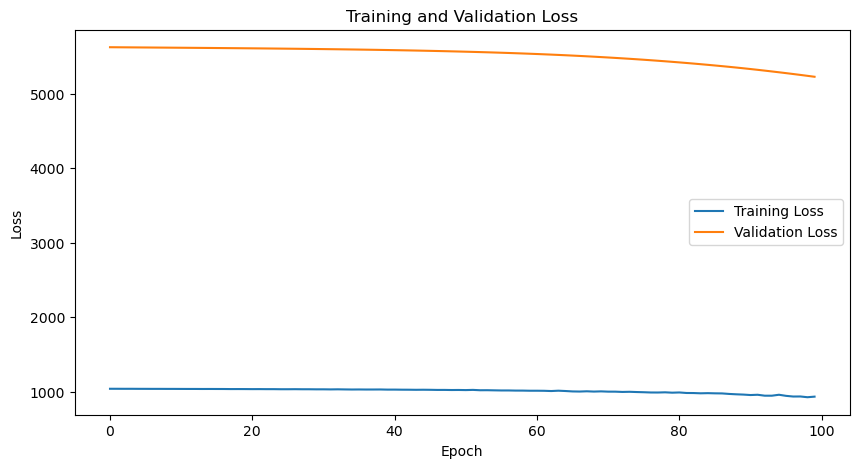

In [12]:
# Evaluate the model on the testing dataset
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss}, Test MAE: {test_mae}")

# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()